<a href="https://colab.research.google.com/github/iamsommyajain/MultiClass-Flower-Classification-Model/blob/main/Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download imsparsh/flowers-dataset

Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
 93% 191M/205M [00:01<00:00, 114MB/s]
100% 205M/205M [00:01<00:00, 113MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flowers-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
DATADIR ='/content/Flowers'
CATEGORIES =['daisy','dandelion','rose','sunflower','tulip']

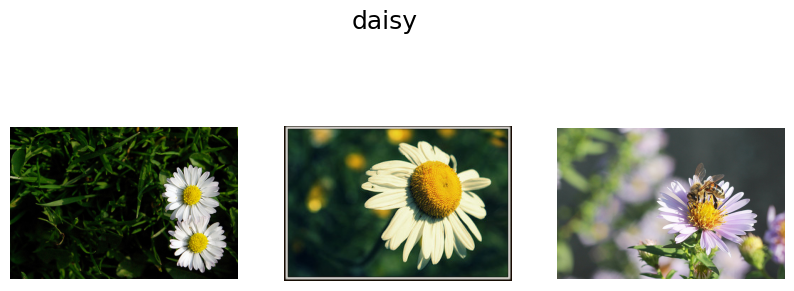

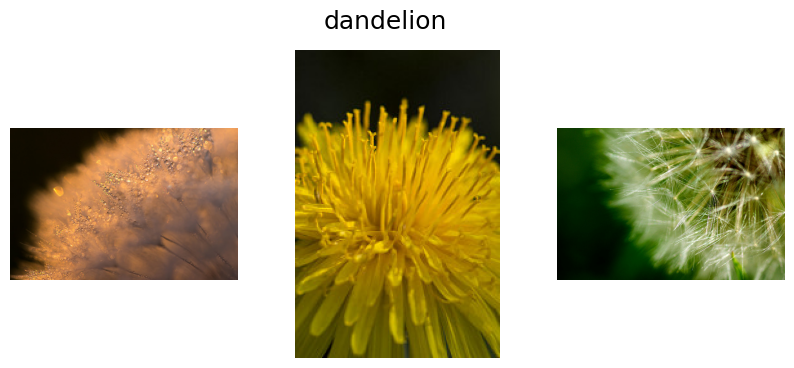

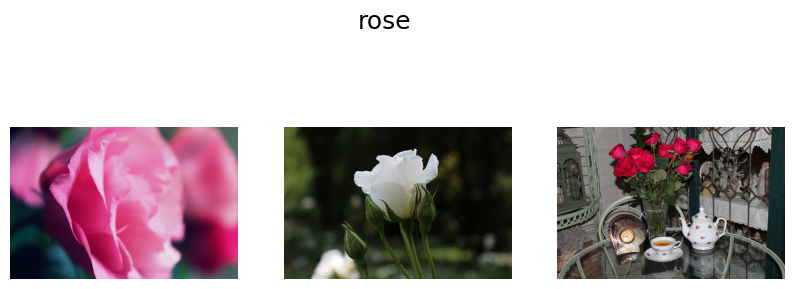

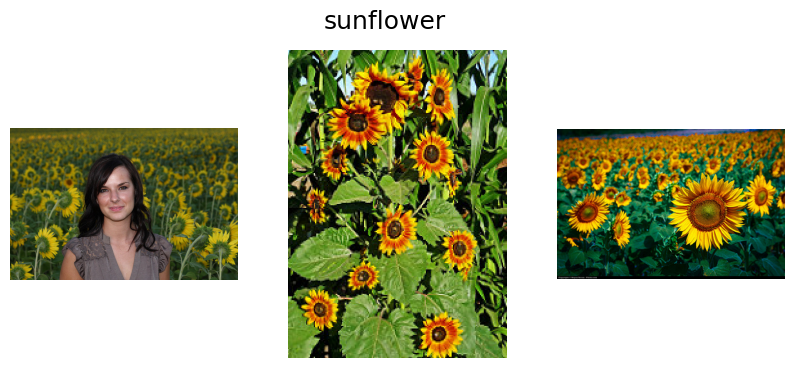

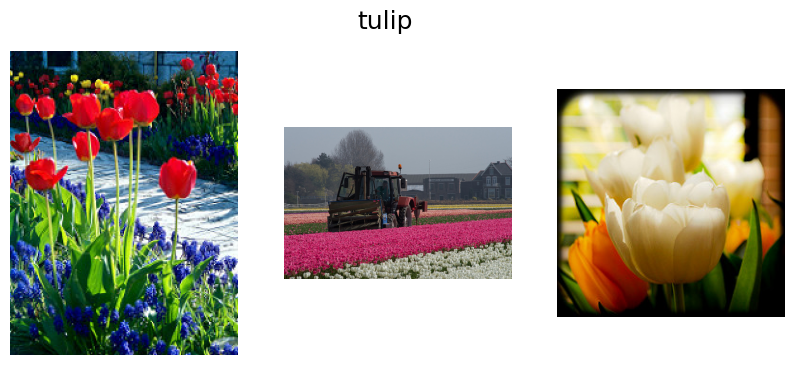

In [6]:
for category in CATEGORIES :
  path = os.path.join(DATADIR,category)
  images = os.listdir(path)

  fig,ax = plt.subplots(1,3, figsize =(10,4))
  fig.suptitle(f'{category}',fontsize=18)

  for i in range(3) :
    img_name=images[np.random.randint(0,len(images))]
    img_path = os.path.join(path,img_name)
    img_array = cv2.imread(img_path)

    img_rgb = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)

    ax[i].imshow(img_rgb)
    ax[i].axis('off')

In [7]:
def count_images(directory) :
  for category in CATEGORIES :
    path = os.path.join(directory,category)
    images = os.listdir(path)
    num_images=len(images)
    print(f'{category} : {len(images)}')
count_images(DATADIR)

daisy : 501
dandelion : 646
rose : 497
sunflower : 495
tulip : 607


Data Augmentation

In [8]:
aug = iaa.Sequential([
    iaa.Fliplr(0.5), #horizontal flips
    iaa.Crop(percent=(0,0.1)), #random crops
    iaa.Affine(scale=(0.8,1.2)), #random scale
    iaa.Affine(rotate=(-25,25)), #random rotation
    iaa.Multiply((0.8,1.2)), #changing brightness
    iaa.LinearContrast((0.75,1.5)) #adjusting contrast
])

def augment_images(directory,CATEGORIES) :
  for category in CATEGORIES :
    path = os.path.join(directory,category)
    images = os.listdir(path)
    for img_name in images :
      img_path = os.path.join(path,img_name)
      img_array = cv2.imread(img_path)
      img_rgb = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
      img_aug = aug.augment_image(img_array)

      new_filename = os.path.splitext(img_name)[0] + '_augmented'+os.path.splitext(img_name)[1]
      new_path = os.path.join(path,new_filename)
      cv2.imwrite(new_path,img_aug)

augment_images(DATADIR,CATEGORIES)

In [9]:
count_images(DATADIR)

daisy : 1002
dandelion : 1292
rose : 994
sunflower : 990
tulip : 1214


In [10]:
img_array.shape

(240, 240, 3)

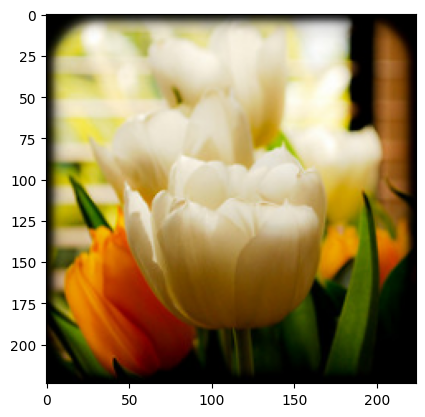

In [11]:
IMG_SIZE = 224
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
img = cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [12]:
training_data = []

def create_training_data(directory) :
  for category in CATEGORIES :
    path = os.path.join(directory,category)
    labels = CATEGORIES.index(category)
    images = os.listdir(path)
    for img_name in images :
      try :
       img_array = cv2.imread(os.path.join(path,img_name))
       img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
       new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
       training_data.append([new_array, labels])
      except Exception as e :
        pass

create_training_data(DATADIR)

In [13]:
len(training_data)

5492

In [14]:
X = []
y = []

for features,labels in training_data :
  X.append(features)
  y.append(labels)

In [15]:
type(X), type (y)

(list, list)

In [16]:
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array(y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
print(f'X_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {y_test.shape}')

X_train shape : (4393, 224, 224, 3)
y_train shape : (4393,)
X_test shape : (1099, 224, 224, 3)
y_test shape : (1099,)


In [19]:
efficient_net = EfficientNetB0(weights='imagenet',
                               include_top=False,
                               input_shape=(IMG_SIZE,IMG_SIZE,3))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Freezing the bottom layers

In [20]:
for layer in efficient_net.layers :
  layer.trainable=False

In [23]:
model = keras.Sequential([
    efficient_net,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(5, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.7923 - loss: 0.5245
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9650 - loss: 0.0994
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9754 - loss: 0.0664
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9798 - loss: 0.0607
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9851 - loss: 0.0387
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9941 - loss: 0.0214
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9900 - loss: 0.0372
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9866 - loss: 0.0396
Epoch 9/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9908 - loss: 0.0257
Epoch 10/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9914 - loss: 0.0243
Epoch 11/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9939 - loss: 0.0196
Epoch 12/50
138/138 ━━━━━━━━━━━━━━━━━━

In [25]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss : {loss}')
print(f'Test accuracy : {accuracy*100}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9604 - loss: 0.2532
Test loss : 0.20212025940418243
Test accuracy : 95.81437706947327


In [26]:
pred = np.argmax(model.predict(X_test), axis=-1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [27]:
pred

array([4, 0, 2, ..., 0, 1, 4])

In [31]:
y_test[10:15]

array([1, 4, 3, 1, 3])

In [30]:
pred[10:15]

array([1, 4, 3, 1, 3])

In [33]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       214
           1       0.97      0.98      0.97       256
           2       0.93      0.95      0.94       182
           3       0.95      0.98      0.96       187
           4       0.96      0.93      0.95       260

    accuracy                           0.96      1099
   macro avg       0.96      0.96      0.96      1099
weighted avg       0.96      0.96      0.96      1099



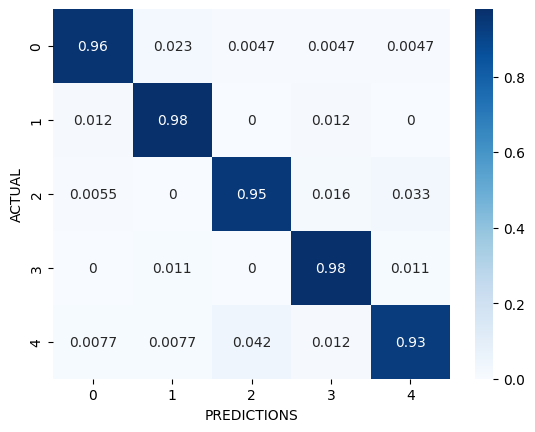

In [35]:
cf = confusion_matrix(y_test,pred, normalize ='true')
sns.heatmap(cf, annot =True, cmap='Blues')
plt.xlabel('PREDICTIONS')
plt.ylabel('ACTUAL')
plt.show()